# Trabalho 4 - K-means, PCA e Arvores de decisão

## Código + Relatório

## Código:

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

## K-means

In [34]:
class K_means():
    def __init__(self, k_):
        self.k_ = k_
    
    def euclidian_distance(self, straight1, straight2):
        return np.sqrt(((straight1 - straight2)**2).sum())

    def assign_group(self, X):
        self.classes = {}
        for i in range(self.k_):
            self.classes[i] = np.zeros(X.shape[1])

        for x in X:
            distances = np.array([self.euclidian_distance(x, centroid) for centroid in self.centroids])
            label = np.argmin(distances)
            self.classes[label] = np.vstack((self.classes[label], x))

    def cal_centroids(self, X):
        previous = self.centroids
        optimal = False
        
        while(not optimal):    
            countDifferents = 0
            for label in self.classes:
                self.centroids[label] = np.average(self.classes[label], axis = 0)

                if(not (previous[label] == self.centroids[label]).all()):
                    countDifferents += 1

            if(countDifferents == 0):
                optimal = True

            if(not optimal):
                self.assign_group(X)

    def fit(self, X):
        self.centroids = np.empty((self.k_, X.shape[1]), float)
        for i in range(self.k_):
            self.centroids[i] = np.array([np.random.randint(np.min(X[:, j]), np.max(X[:, j])) for j in range(X.shape[1])])

        self.assign_group(X)
        self.cal_centroids(X)

    def predict(self, X):
        self.class_distance = np.array([])
        predicted = np.array([])
        for x in X:
            distances = np.array([self.euclidian_distance(x, centroid) for centroid in self.centroids])
            label = np.argmin(distances)
            self.class_distance = np.append(self.class_distance,np.min(distances))
            predicted = np.append(predicted, label)

        return predicted

In [35]:
def k_fold (X, y, k, metodo):
    e = np.array([])
    part = 1/k
    qtd_part = int(X.shape[0] * part)
    
    for i in range(0, k):
        init_part = qtd_part * i
        end_part = qtd_part * (i+1)
        
        X_train = X[init_part:end_part, :]
        y_train = y[init_part:end_part]
        
        X_test = X[:init_part, :]
        X_test = np.vstack((X_test, X[end_part:, :]))
            
        y_test = y[0:init_part]
        y_test = np.append(y_test, y[end_part:])
                
        metodo.fit(X_train, y_train)
        y_pred = metodo.predict(X_test)
        
        e = np.append(e, acuracia(y_test, y_pred))
                      
    return print("Erros: ", e)

## PCA

In [36]:
class PCA():
    def __init__(self, n_components):
        self.n_components_ = n_components

    def cal_covariance(self, X):
        n = X.shape[0]
        return ((X - np.mean(X, axis=0)).T @ (X - np.mean(X, axis=0))) / (n - 1)
    
    def fit(self, X):
        X = StandardScaler().fit_transform(X)
        covariance = self.cal_covariance(X)
        values, vectors = np.linalg.eig(covariance)
        indices = (-values).argsort()[:self.n_components_]
        self.w = vectors[:, indices]
        self.variance = np.array([])
        
        for i in indices:
            self.variance = np.append(self.variance, values[i] / values.sum())

    def transform(self, X):
        X = StandardScaler().fit_transform(X)
        return (self.w.T @ X.T).T

In [37]:
def acuracia(y_true, y_pred):
    count = 0;
    for t, p in zip(y_true, y_pred):
        if t == p:
            count += 1
    return (count / y_true.shape[0])

In [38]:
def k_fold (X, y, k, metodo):
    e = np.array([])
    part = 1/k
    qtd_part = int(X.shape[0] * part)
    
    for i in range(0, k):
        init_part = qtd_part * i
        end_part = qtd_part * (i+1)
        
        X_train = X[init_part:end_part, :]
        y_train = y[init_part:end_part]
        
        X_test = X[:init_part, :]
        X_test = np.vstack((X_test, X[end_part:, :]))
            
        y_test = y[0:init_part]
        y_test = np.append(y_test, y[end_part:])
                
        metodo.fit(X_train, y_train)
        y_pred = metodo.predict(X_test)
        
        e = np.append(e, acuracia(y_test, y_pred))
                      
    return print("Erros: ", e)

## Árvore de decisão

In [40]:
class Node:
    def __init__(self, data, feature):
        self.feature = feature
        self.value = data
        self.left = None
        self.right = None

In [41]:
class DecisionTree_Classifier():
    def __init__(self):
        self._estimator_type = "classifier"

    def count_unique(self, y):
        (unique, counts) = np.unique(y, return_counts=True)
        freq = {}
        for i in range(len(unique)):
            freq[unique[i]] = counts[i]
        return freq

    def cal_gini(self, X, y, feature, value):
        x = X[:, feature]
        left = {
            'total': 0
        }
        right = {
            'total': 0
        }
        
        for class_value in set(y):
            left[class_value] = 0
            right[class_value] = 0

        for i in range(len(x)):
            if x[i] > value:
                right['total'] += 1
                right[y[i]] += 1
            else:
                left['total'] += 1
                left[y[i]] += 1

        left_gini = 0
        right_gini = 0

        for class_value in set(y):
            if left['total'] > 0:
                left_gini += (left[class_value] / left['total'])  ** 2
            if right['total'] > 0:
                right_gini += (right[class_value] / right['total'])  ** 2
        
        left_gini = 1 - left_gini
        right_gini = 1 - right_gini

        class_freq = self.count_unique(y)
        gini_root = 0
        for class_value in set(y):
            gini_root += (class_freq[class_value] / y.shape[0]) ** 2

        return 1 - gini_root

    def build_decision_tree(self,X,y, features):
        if len(set(y)) == 1:
            value = y[0]
            return Node(value, None)
            
        if X.shape[0] == 0 or X.shape[1] == len(features):
            class_freq = self.count_unique(y)
            max_count = -math.inf
            value = None
            for i in set(y):
                if i in class_freq:
                    if class_freq[i] > max_count:
                        value = i
                        max_count = class_freq[i]
            return Node(value, None)

        max_gain = -math.inf
        final_feature = None
        final_value = None

        for feature in range(X.shape[1]):
            if (feature not in features):
                for value in np.unique(X[feature]):
                    current_gain = self.cal_gini(X, y, feature, value)

                if current_gain > max_gain:
                    max_gain = current_gain
                    final_feature = feature
                    final_value = value

        left_y = y[X[:, final_feature] <= final_value]
        right_y = y[X[:, final_feature] > final_value]     
        left_X = X[X[:, final_feature] <= final_value]
        right_X = X[X[:, final_feature] > final_value]    
        features.append(final_feature)

        left = self.build_decision_tree(left_X, left_y, features)
        right = self.build_decision_tree(right_X, right_y, features)
        root = Node(final_value, final_feature)
        root.left = left
        root.right = right
        return root
        
    def fit(self,X,y):
        features = []
        self.classes_ = np.unique(y)
        self.root = self.build_decision_tree(X, y, features)

    def predict(self, X):
        predict = np.array([])
        for x in X:
            root = self.root
            while(not (root.feature is None)):
                if(x[root.feature] > root.value):
                    root = root.right
                else:
                    root = root.left
            
            predict = np.append(predict, root.value)
        
        return predict

## Carregando e dividindo o conjunto de dados 

In [42]:
data = np.loadtxt("./trab4.data", delimiter=",")

X = data[:,:-1]
y = data[:, -1]

## Relatório:

## K-means

k-means:


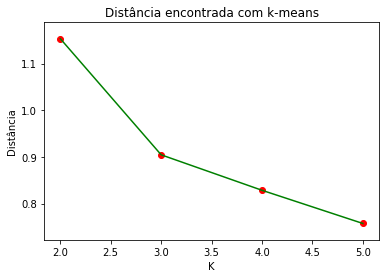

In [44]:
print("k-means:")
mean_distance = np.array([])
for k in range(2, 6):
    distance = 0
    for _ in range(20):
        k_means = K_means(k)
        k_means.fit(X)
        k_means.predict(X)
        distance += k_means.class_distance.mean()
    mean_distance = np.append(mean_distance, distance/20)

plt.scatter(range(2,6), mean_distance, color='red')
plt.plot(range(2,6), mean_distance, color='green')

plt.title("Distância encontrada com k-means")
plt.xlabel("K")
plt.ylabel("Distância")
plt.show()

### O melhor valor para K é 3, pois o modelo se adaptou até bem aos dados e também porque os dados estão divididos em 3 categorias.

## PCA

Variância preservada: 0.9580097536148198


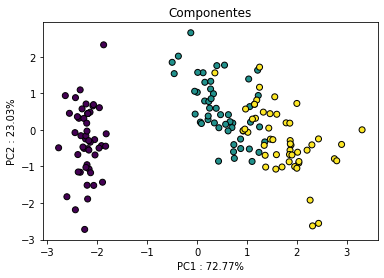

In [45]:
pca = PCA(2)
pca.fit(X)
X = pca.transform(X)

print("Variância preservada: {}".format(pca.variance.sum()))

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Componentes")
plt.xlabel('PC1 : {:.2f}%'.format(pca.variance[0] * 100))
plt.ylabel('PC2 : {:.2f}%'.format(pca.variance[1] * 100))
plt.show()

## Árvore de decisão

In [47]:
DT_C = DecisionTree_Classifier()

k_fold(X, y, 5, DT_C)

Erros:  [0.16666667 0.39166667 0.16666667 0.5        0.16666667]
